In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import artm

batch_vectorizer = artm.BatchVectorizer(data_path='datasets/mmro_order', data_format='batches')

background_topics = []
domain_topics = []
all_topics = []

for i in range(0, 52):
    if i < 50:
        topic_name = str(i)
        domain_topics.append(topic_name)
    else:
        topic_name = "b" + str(i)
        background_topics.append(topic_name)
    all_topics.append(topic_name)
        
def prepare(model):
    model.load_dictionary(dictionary_name='dictionary', dictionary_path='datasets/mmro_order/dictionary')
    model.initialize(dictionary_name='dictionary')
    # will this cooc dictionaries match?
    model.load_dictionary(dictionary_name='pPMI_w100', dictionary_path='datasets/mmro/pPMI_w100_dictionary')
    model.load_dictionary(dictionary_name='pPMI_doc', dictionary_path='datasets/mmro/pPMI_doc_dictionary')
 
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                      use_unigram_document_model=False, # где-то сохраняется, сколько раз pwd = 0?
                                      dictionary_name='dictionary'))

    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', 
                                           topic_names = domain_topics))

    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', 
                                            topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop10_pPMI_w100', 
                                         num_tokens=10, 
                                         dictionary_name = 'pPMI_w100',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop100_pPMI_w100', 
                                         num_tokens=100, 
                                         dictionary_name = 'pPMI_w100',
                                         topic_names = domain_topics))
    
    model.scores.add(artm.TopTokensScore(name='DomainTop10_pPMI_doc', 
                                         num_tokens=10, 
                                         dictionary_name = 'pPMI_doc',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop100_pPMI_doc', 
                                         num_tokens=100, 
                                         dictionary_name = 'pPMI_doc',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='BackgroundTopTokensScore', 
                                         num_tokens=10, 
                                         topic_names = background_topics))

    model.scores.add(artm.TopicKernelScore(name='DomainTopicKernel_pPMI_w100', 
                                           probability_mass_threshold=0.25, 
                                           dictionary_name = 'pPMI_w100',
                                           topic_names = domain_topics))
    
    model.scores.add(artm.TopicKernelScore(name='DomainTopicKernel_pPMI_doc', 
                                           probability_mass_threshold=0.25, 
                                           dictionary_name = 'pPMI_doc',
                                           topic_names = domain_topics))

    model.scores.add(artm.TopicKernelScore(name='BackgroundTopicKernelScore', 
                                           probability_mass_threshold=0.25, 
                                           topic_names = background_topics))
    
    model.scores.add(artm.TopicMassPhiScore(name='BackgroundMassScore',  
                                           topic_names = background_topics))

def figures(model):
    # row and column sharing
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', figsize=(15,8))
    plt.subplots_adjust(hspace = 0.3, wspace = 0.25)
    #f.set_size_inches(18.5, 10.5)
    
    # perplexity
    x = range(model.num_phi_updates)[1:]
    ax1.plot(x, model.score_tracker['PerplexityScore'].value[1:], 'g-', linewidth=2, label="Perplexity")
    ax1.set_ylabel('Perplexity', color='g')
    ax11 = ax1.twinx()
    ax11.plot(x, model.score_tracker['SparsityPhiScore'].value[1:], 'r*', linewidth=2, label="Phi")
    ax11.plot(x, model.score_tracker['SparsityThetaScore'].value[1:], 'r--', linewidth=2, label="Theta ")
    ax11.plot(x, model.score_tracker['BackgroundMassScore'].value[1:], 'r^', linewidth=2, label="Back")
    ax11.set_ylabel('Ratio', color='r')
    ax11.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
    ax1.grid(True)
    
    # kernels
    x = range(model.num_phi_updates)[1:]
    ax2.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_size[1:], 'g-', linewidth=2, label="size")
    ax2.set_ylabel('Kernel size', color='g')
    ax22 = ax2.twinx()
    ax22.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
    ax22.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_purity[1:], 'r--', linewidth=2, label="purity")
    ax22.set_ylabel('Ratio', color='r')
    ax22.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    ax2.grid(True)
    
    # coherence
    x = range(model.num_phi_updates)[1:]
    ax3.plot(x, model.score_tracker['DomainTop10_pPMI_w100'].average_coherence[1:], 'b--', label="top10", linewidth=2)
    ax3.plot(x, model.score_tracker['DomainTop100_pPMI_w100'].average_coherence[1:], 'r--', label="top100", linewidth=2)
    ax3.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_coherence[1:], 'g--', label="kernel", linewidth=2)
    ax3.set_ylabel('Window100 pPMI coherence')
    ax3.set_xlabel('Iterations count')
    ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
    ax3.grid(True) 
    
    # coherence
    x = range(model.num_phi_updates)[1:]
    ax4.plot(x, model.score_tracker['DomainTop10_pPMI_doc'].average_coherence[1:], 'b--', label="top10", linewidth=2)
    ax4.plot(x, model.score_tracker['DomainTop100_pPMI_doc'].average_coherence[1:], 'r--', label="top100", linewidth=2)
    ax4.plot(x, model.score_tracker['DomainTopicKernel_pPMI_doc'].average_coherence[1:], 'g--', label="kernel", linewidth=2)
    ax4.set_ylabel('Document pPMI coherence')
    ax4.set_xlabel('Iterations count')
    ax4.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
    #ax4.legend(loc=2)
    ax4.grid(True)

     

### ARTM: сглаживание, разреживание, декоррелирование

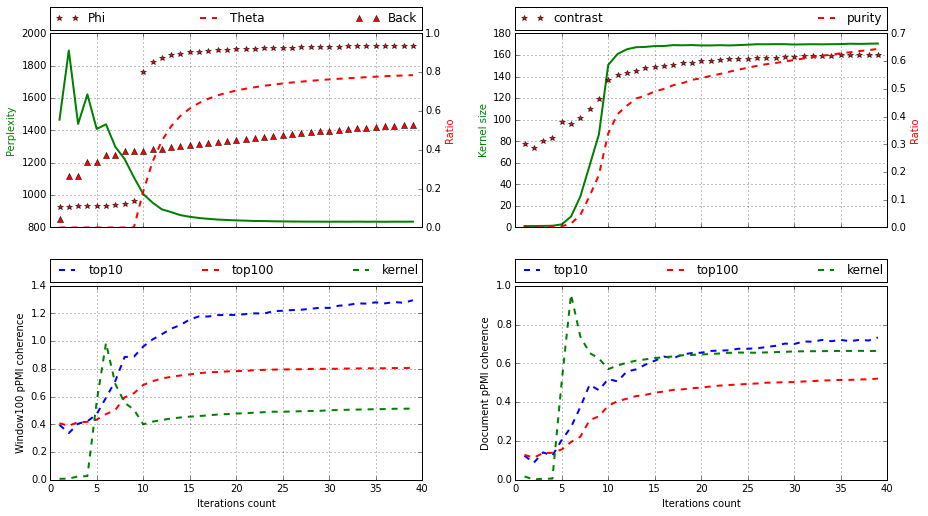

In [2]:
model = artm.ARTM(topic_names = all_topics, num_processors=3)
prepare(model)

model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10, use_ptdw_matrix=True)

model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.5, topic_names=domain_topics))
markup, topic_names = model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30, 
                                        use_ptdw_matrix=True, find_ptdw=True)

figures(model)

### Save matrices:

In [4]:
import pandas
phi = model.phi_.sort(axis=0)
theta = model.fit_transform().sort(axis=1)

In [5]:
for i in range(theta.as_matrix().shape[0]):
    if theta.as_matrix()[i][738] != 0:
        print i, theta.as_matrix()[i][738]

43 0.309684
50 0.180222
51 0.510094


In [6]:
import numpy as np
np.save("theta", theta.as_matrix())
np.save("phi", phi.as_matrix())

In [6]:
import codecs
texts = []
titles = []
with codecs.open("datasets/mmro_order/vw.mmro.txt", "r", encoding='utf-8') as f:
    for line in f:
        l = line.split()
        titles.append(l[0])
        texts.append(l[1:])

In [7]:
text_id = 738
print titles[text_id]
for i in range(len(texts[text_id])):
    print texts[text_id][i], markup[text_id + 1][i], "  ",

2013-MMRO16/Shibzukhov_2
агрегированный 30    корректный 34    операция 34    алгоритм 51    агрегированный 30    корректный 34    операция 34    алгоритм 51    матросов 43    шибзухов 43    матросов 43    виктор 43    шибзухов 43    настоящий 7    работа 50    обсуждаться 21    корректный 34    операция 34    алгоритм 51    возникать 4    связь 3    проблема 7    построение 51    корректный 34    алгоритм 51    корректный 34    операция 34    образовать 14    значительный 34    подкласс 34    корректировать 34    операция 34    обладать 14    важный 21    свойство 6    сохранять 47    свойство 6    корректность 20    алгоритм 51    типичный 49    задача 50    поиск 50    корректный 34    операция 34    возникать 4    использовать 3    метод 51    обучение 51    позволять 50    строить 49    множество 51    различный 50    алгоритм 51    корректный 34    свой 30    обучать 51    множество 51    обладать 14    достаточно 8    хороший 29    качество 51    функционирование 24    контроль 

In [8]:
import codecs
with codecs.open("ptdw.txt", "w", encoding='utf-8') as fout:
    for doc_id in range(len(markup.keys())):
        for i in range(len(markup[doc_id + 1])):
            print>>fout, markup[doc_id + 1][i],
        print>>fout